# Anomaly detection algorithms

datasource: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data

Anomaly detection techniques are commonly employed in predictive maintenance strategies to identify abnormal patterns or behaviors in machine data.

By monitoring various sensor readings, operational parameters, or other relevant data from machines, anomaly detection algorithms can learn the normal behavior or expected patterns of the machines during their normal operation. When a deviation from the normal behavior is detected, it may indicate a potential failure or malfunction.

The problem of anomaly detection comes to detection of outliers.  
The hypothesis is that the sensor readings of a pump will generate abnormal values in case of an (upcoming) failure, and these can be determined with unsupervised learning algorithms.  


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

from sklearn.metrics import (mean_absolute_error, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             RocCurveDisplay,
                            roc_auc_score, 
                             silhouette_score, 
                             davies_bouldin_score)


from sklearn.decomposition import PCA


[Inspecting the data](#inspect)  
- [Visualisation](#visual)  

[Feature selection](#feature)
- [PCA](#pca)  
- [Anomalies detection](#anomalies)  
    - [Isolation Forest](#forest)
    - [DBSCAN](#dbscan)  
    - [XGBoost](#xgb)  
- [Clustering sensors](#clusters)

[Conclusion](#conclusion)

## <a id='inspect'>Inspecting the data</a>

In [2]:
df = pd.read_csv('sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [3]:
#Deleting the 'Unnamed' column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.shape

(220320, 54)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

<AxesSubplot:>

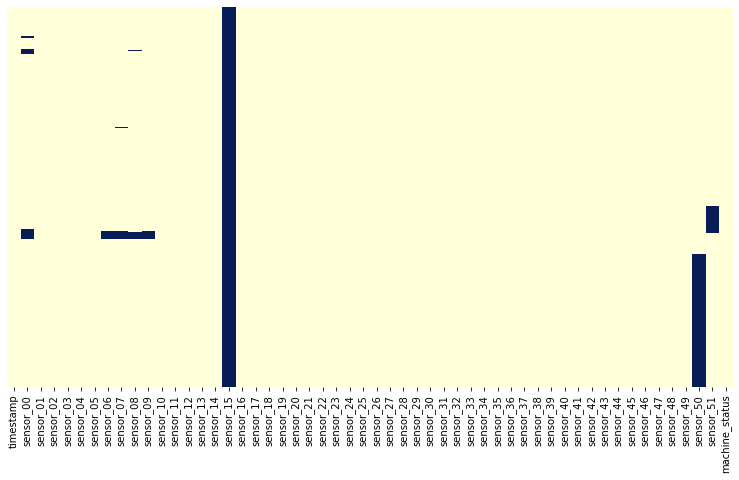

In [6]:
#visualization of missing values
plt.figure(figsize=(13, 7))
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='YlGnBu')

In [7]:
#missing values
percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
percentage_missing.head() # show 5 largest missing %

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
dtype: float64

In [8]:
#looking into the machine status values distribution
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

Common obstacle when dealing with anomaly detection problems is that classes are usually imbalanced, which is also the case with the current dataset.

In [9]:
df[df['machine_status']=='BROKEN'].describe().T

,count,mean,std,min,25%,50%,75%,max
sensor_00,7.0,1.194188,1.096684,0.000000,0.182986,1.093982,2.288802,2.321759
sensor_01,7.0,45.969742,4.167754,40.190970,43.836805,45.833332,47.374135,53.342010
sensor_02,7.0,50.837052,3.115010,45.225690,49.587671,52.734370,52.864585,52.994790
sensor_03,7.0,42.931546,1.682742,40.190971,42.122393,43.402775,43.663194,45.355900
sensor_04,7.0,334.672200,173.963706,200.115738,201.947327,206.038757,460.251724,612.152800
sensor_05,7.0,45.351953,31.315537,0.000000,25.597100,60.301060,66.724005,72.520400
sensor_06,7.0,9.818328,5.761857,0.028935,7.277200,12.304690,13.827400,14.185470
sensor_07,7.0,13.731811,6.073307,0.036169,15.212670,15.914350,16.427955,16.890910
sensor_08,7.0,13.294684,5.904074,0.036169,14.666520,15.183740,15.820315,16.869210
sensor_09,7.0,12.788318,5.660497,0.007234,14.330150,15.053530,15.100550,15.596060


There is no correlation between status 'broken' and NaN values

In [10]:
# excluding columns with a big amount of NaN values
df.drop(['sensor_15', 'sensor_50'], inplace = True, axis=1)

# set timestamp to date
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'].min(),' - ',df['timestamp'].max())
#timestamp as index
df = df.set_index('timestamp')

2018-04-01 00:00:00  -  2018-08-31 23:59:00


The dataset contains information on a water pump machine collected by means of 51 sensors. The data had been collected for a period of 5 months. Sensors 15 and 50 were excluded from the further nalysis due to a large volume of missing data. There were only 7 cases of machine breaking down.

In [11]:
#filling empty values with column's mean
df.fillna(df.mean(), inplace=True)

### <a id='visual'>Visualisation</a>

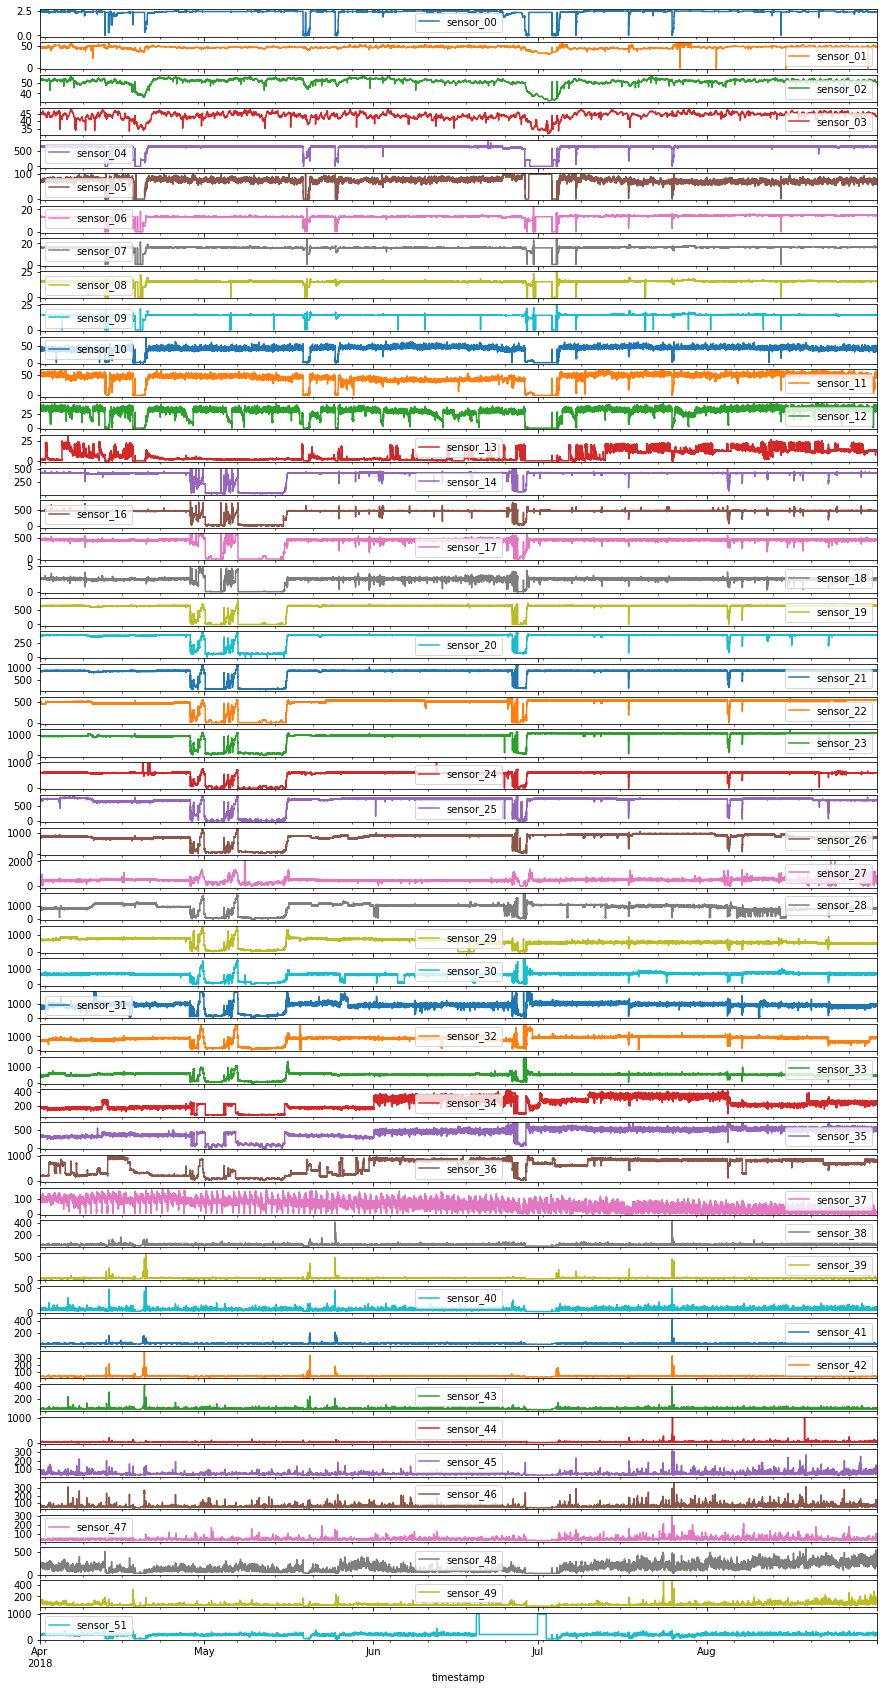

In [12]:
df.plot(subplots=True, sharex=True, figsize=(15, 30));

There are clearly groups of sensors that follow the same pattern.

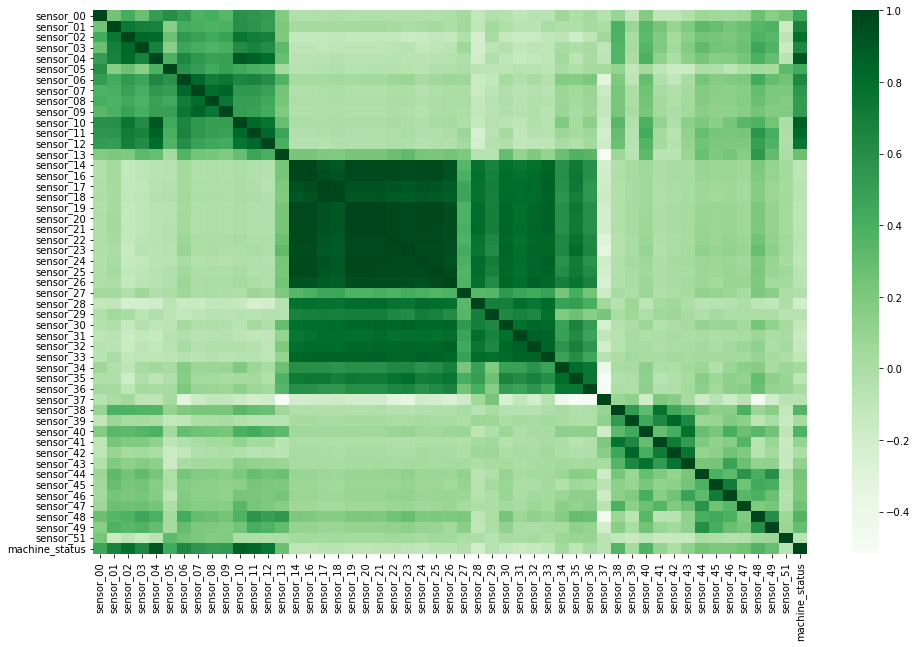

In [13]:
#correlation matrix
df_corr = df.copy()
df_corr['machine_status'] = df['machine_status'].map({"NORMAL": 1, "RECOVERING": -1, "BROKEN": -1})
corr = df_corr.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr, cmap="Greens",annot=False);

First 13 sensors show high correlation with the machine status. However, most of them collect the same data which gives such high correlation between sensors. Perhaps reducing dimensionality with PCA or grouping sensors should be done.

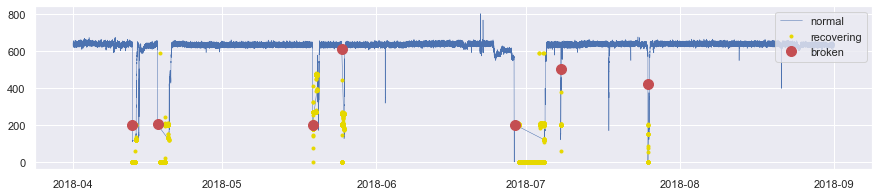

In [14]:
sns.set()
plt.figure(figsize=(15, 3))
plt.plot(df[df['machine_status']=='NORMAL']['sensor_04'],
         linewidth=0.5, label='normal')
plt.plot(df[df['machine_status']=='RECOVERING']['sensor_04'], 
         linestyle='none', marker='o', markersize=3, color='#e6d800', label='recovering')
plt.plot(df.loc[df['machine_status']=='BROKEN']['sensor_04'], 
         "ro", markersize=10, label='broken')
plt.legend(loc="upper right");

In [15]:
def visualize_status(df, predictions=''):
    """
    Machine status visualisation
    df: DataFrame,
    predictions: str, column name 
    """
    sns.set()
    plt.figure(figsize=(15, 3))
    plt.plot(df['machine_status'].map({"NORMAL": 1,"RECOVERING": -1,"BROKEN": -1}))
    plt.plot(df[df['machine_status']=='RECOVERING']['machine_status'].map({"RECOVERING": -1}), 
             linestyle='none', marker='o', markersize=3, color='#e6d800', label='recovering')
    plt.plot(df[df['machine_status']=='BROKEN']['machine_status'].map({"BROKEN": -1}), 
             "ro", markersize=10, label='broken')
    if len(predictions)>0:
        plt.plot(df[df[predictions]==-1][predictions], 
                 linestyle='none', marker='o', markersize=0.8, color='#e60049',label='predicted anomaly')
    plt.title('Machine status')
    plt.xlabel('Date')
    plt.legend(loc="upper right");

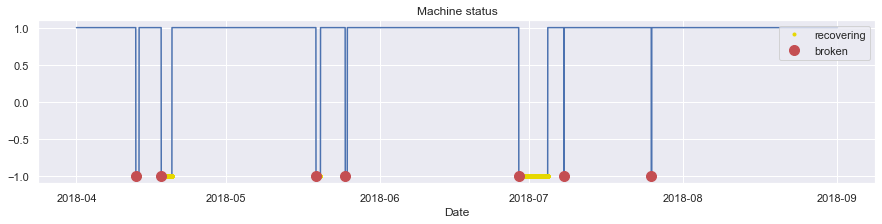

In [16]:
visualize_status(df)

In [17]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
    series: DataFrame, dataframe with timeseries
    window: int, rolling window size
    plot_intervals: bool, show confidence intervals
    plot_anomalies: bool, show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20, 8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], linewidth=0.5, label="Actual values")
    plt.legend(loc="upper right")
    plt.grid(True)

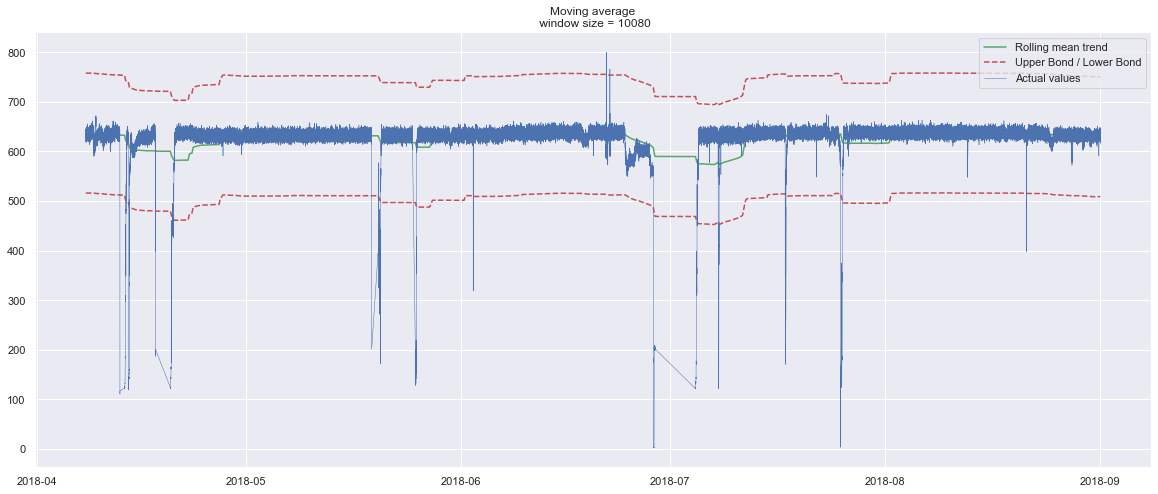

In [18]:
plotMovingAverage(df[df['machine_status']=='NORMAL']['sensor_04'], 
                  10080, plot_intervals=True)

## <a id='pca'>PCA</a>

Since all of these sensors represent different parts of the machine (motors, pumps, etc.), each has different range of values. Perhaps performing PCA will allow us to reduce the dimensionality and allow us to get more clear results from the anomaly detection methods.

In [19]:
# creating feature matrix X
X = df.drop('machine_status', axis=1)
y = df['machine_status']
X.shape

(220320, 50)

In [20]:
# Scaling
scaler = StandardScaler()
pca = PCA()
pca_pipeline = make_pipeline(scaler, pca)
pca_pipeline.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

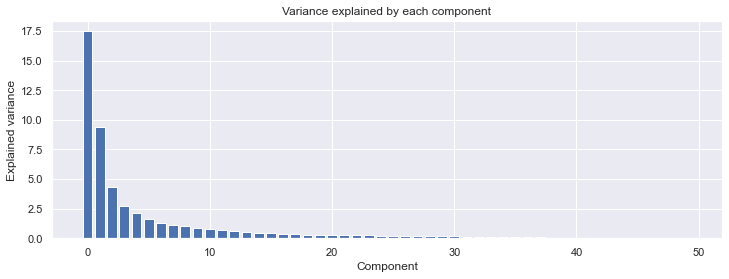

In [21]:
plt.figure(figsize=(12, 4))
plt.bar(height=pca.explained_variance_, x=range(pca.n_components_))
plt.title('Variance explained by each component')
plt.ylabel('Explained variance')
plt.xlabel('Component');


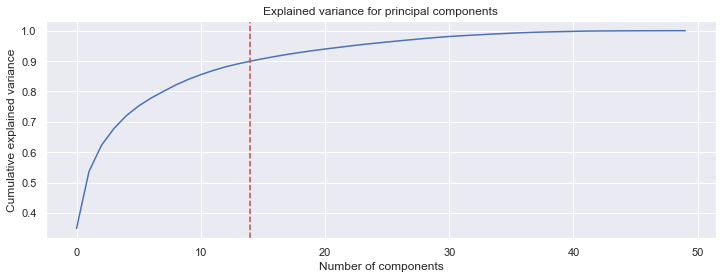

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance for principal components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axvline(x=14, c='r', linestyle='--');

Approximately 14 components explain 90% of variance in the data.

In [23]:
X_sc = scaler.fit_transform(X)
pca = PCA(n_components=14, svd_solver = 'full')
X_pc = pca.fit_transform(X_sc)

In [24]:
X_pc.shape

(220320, 14)

In [25]:
# get the index (out of 50) of the most important feature (largest loading) per each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(len(pca.components_))]

sensor_names = list(df.iloc[:,:-1].columns)
# mapping indices to the sensors
most_important_sensors = [sensor_names[most_important[i]] for i in range(len(pca.components_))]
most_important_sensors

['sensor_21',
 'sensor_11',
 'sensor_42',
 'sensor_37',
 'sensor_51',
 'sensor_45',
 'sensor_47',
 'sensor_00',
 'sensor_27',
 'sensor_27',
 'sensor_45',
 'sensor_13',
 'sensor_51',
 'sensor_01']

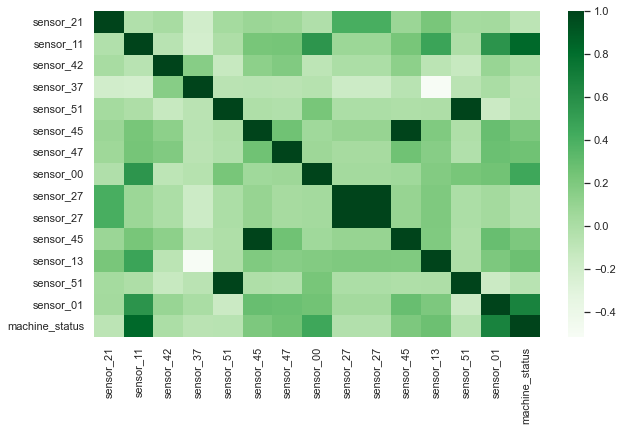

In [26]:
pc_corr = df_corr[most_important_sensors + ['machine_status']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(pc_corr, cmap="Greens",annot=False);

In [27]:
X_reduced_df = pd.DataFrame(X_pc)
X_reduced_df.columns = most_important_sensors
X_reduced_df['machine_status'] = df['machine_status'].to_list()
X_reduced_df.index = df.index.values
X_reduced_df.head()

,sensor_21,sensor_11,sensor_42,sensor_37,sensor_51,sensor_45,sensor_47,sensor_00,sensor_27,sensor_27,sensor_45,sensor_13,sensor_51,sensor_01,machine_status
2018-04-01 00:00:00,-0.046056,0.490524,-0.470246,-0.429740,-1.837898,1.535642,-1.101365,-0.028537,-1.101983,-0.954902,-0.285237,-0.150515,0.251641,-0.249574,NORMAL
2018-04-01 00:01:00,-0.046056,0.490524,-0.470246,-0.429740,-1.837898,1.535642,-1.101365,-0.028537,-1.101983,-0.954902,-0.285237,-0.150515,0.251641,-0.249574,NORMAL
2018-04-01 00:02:00,-0.186309,0.500354,-0.441182,-0.480855,-2.021764,1.501945,-1.121741,0.068834,-0.963554,-0.815661,-0.306879,-0.152692,0.094549,-0.184514,NORMAL
2018-04-01 00:03:00,-0.186651,0.538034,-0.489395,-0.625738,-1.953825,1.585233,-1.170793,0.051011,-0.832947,-0.686467,-0.299751,-0.136788,0.168459,-0.242838,NORMAL
2018-04-01 00:04:00,-0.142655,0.645878,-0.355112,-0.677397,-1.928197,1.510222,-1.156190,-0.029794,-1.123520,-0.853227,-0.173136,-0.072259,0.081003,-0.183000,NORMAL


## <a id='anomalies'>Anomalies detection</a>

### <a id='forest'>Isolation Forest</a>

In [28]:
outliers_fraction = 1 - (len(df.loc[df['machine_status']=='NORMAL'])/(len(df))) 
print(outliers_fraction)

0.06574074074074077


In [29]:
#Isolation forest on raw data
iso_forest = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
print(iso_forest)

y_pred = iso_forest.fit(X_sc).predict(X_sc)
df['isolation_forest'] = y_pred
print('number of anomolies detected')
print(df['isolation_forest'].value_counts())

IsolationForest(contamination=0.06574074074074077, n_jobs=-1)
number of anomolies detected
 1    205836
-1     14484
Name: isolation_forest, dtype: int64


In [30]:
def evaluate_results(df, algorithm):
    print(classification_report(df['machine_status'].map(
        {"NORMAL": 1,"RECOVERING": -1,"BROKEN": -1}), 
                                df[algorithm]))
    print('ROC AUC score: ', roc_auc_score(df['machine_status']
                                           .map({"NORMAL": 1, 
                                                 "RECOVERING": -1, 
                                                 "BROKEN": -1}), 
                                           df[algorithm]))
    #confusion matrix metrics
    cm = confusion_matrix(df['machine_status'].map({
        "NORMAL": 1, "RECOVERING": -1, "BROKEN": -1}), 
                          df[algorithm])
    tn, fp, fn, tp = cm.ravel()
    #visualising confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

              precision    recall  f1-score   support

          -1       0.41      0.41      0.41     14484
           1       0.96      0.96      0.96    205836

    accuracy                           0.92    220320
   macro avg       0.68      0.68      0.68    220320
weighted avg       0.92      0.92      0.92    220320

ROC AUC score:  0.682267217248574


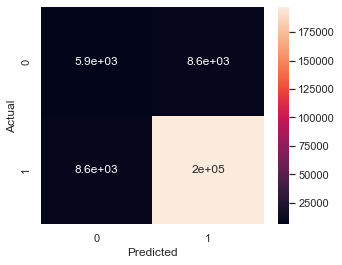

In [31]:
evaluate_results(df, 'isolation_forest')

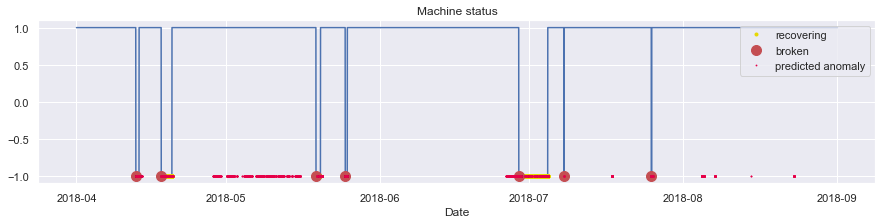

In [32]:
visualize_status(df, 'isolation_forest')

In [33]:
#PCA+Isolation Forest
X_reduced = X_reduced_df.iloc[:,:-1]
algorithm = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
print(algorithm)

y_pred = algorithm.fit(X_reduced).predict(X_reduced)
X_reduced_df['isolation_forest'] = y_pred
print('number of anomolies detected')
print(X_reduced_df['isolation_forest'].value_counts())

IsolationForest(contamination=0.06574074074074077, n_jobs=-1)
number of anomolies detected
 1    205836
-1     14484
Name: isolation_forest, dtype: int64


              precision    recall  f1-score   support

          -1       0.61      0.61      0.61     14484
           1       0.97      0.97      0.97    205836

    accuracy                           0.95    220320
   macro avg       0.79      0.79      0.79    220320
weighted avg       0.95      0.95      0.95    220320

ROC AUC score:  0.7932279739182486


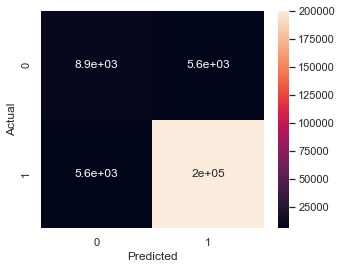

In [34]:
evaluate_results(X_reduced_df, 'isolation_forest')

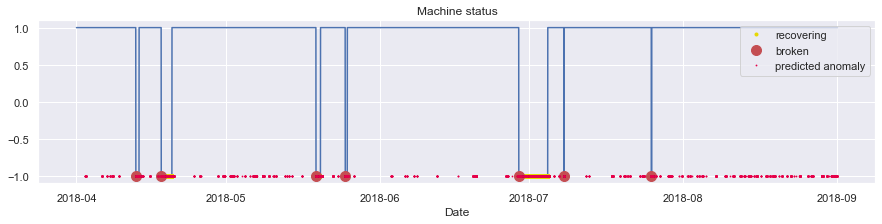

In [35]:
visualize_status(X_reduced_df, 'isolation_forest')

Isolation Forest does detect anomalies when the machine is broken or recovering (6k out of 14k). However, from the visualisation it seems that it doesn't predict anomalies before the malfunctioning.
The algorithm performs slightly better after the PCA, it detected 8.7k anomalies out of 14k. Unfortunately there are still a lot of false positives.

### <a id='dbscan'>DBSCAN</a>
Inspired by the article E. Oliosi, G. Calzavara and G. Ferrari, "On Sensor Data Clustering for Machine Status Monitoring and Its Application to Predictive Maintenance," in IEEE Sensors Journal, vol. 23, no. 9, pp. 9620-9639, 1 May1, 2023, doi: 10.1109/JSEN.2023.3260314.

In [36]:
db = DBSCAN(eps=0.3, min_samples=10)

In [37]:
df['dbscan'] = db.fit_predict(X_sc)
df['dbscan'].value_counts()

-1     216792
 5        604
 30       504
 34       469
 25       210
 3        201
 9        172
 4        162
 23       120
 6        104
 2         91
 28        89
 37        86
 22        80
 21        66
 1         58
 19        50
 36        39
 26        34
 10        30
 24        29
 29        28
 38        28
 20        28
 32        25
 39        20
 7         20
 31        19
 15        15
 18        15
 35        14
 0         14
 17        14
 11        13
 12        11
 8         11
 13        10
 14        10
 33        10
 16        10
 40         8
 27         7
Name: dbscan, dtype: int64

In [38]:
df['dbscan'] = df['dbscan'].apply(lambda x: 0 if x>-1 else -1)

In [39]:
df['dbscan'] = df['dbscan'].map({-1: 1, 0: -1})
df['dbscan'].value_counts()

 1    216792
-1      3528
Name: dbscan, dtype: int64

              precision    recall  f1-score   support

          -1       0.98      0.24      0.39     14484
           1       0.95      1.00      0.97    205836

    accuracy                           0.95    220320
   macro avg       0.97      0.62      0.68    220320
weighted avg       0.95      0.95      0.94    220320

ROC AUC score:  0.6197203626352061


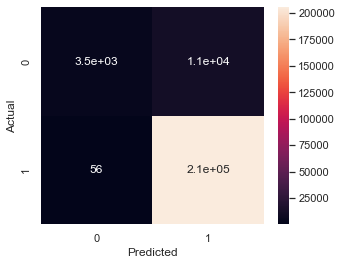

In [41]:
evaluate_results(df, 'dbscan')

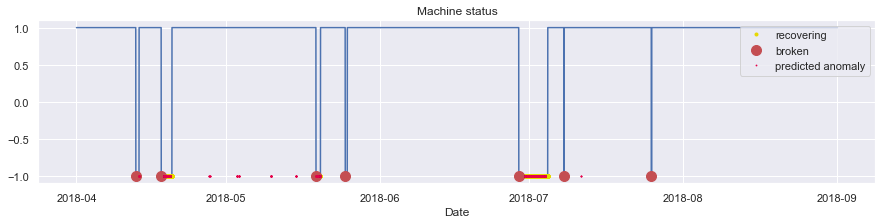

In [42]:
visualize_status(df, 'dbscan')

The number of FN ('normal' status was labeled as anomalous) decreased drastically compared to Isolation Forest. However, ROC AUC score and macro F1 score is almost the same as for the Isolation Forest. From the visualisation we can seen that the algorithm detected anomalies only after the breakage, when machine was in a 'recovering' state.

In [43]:
#PCA+DBSCAN
db = DBSCAN(eps=0.3, min_samples=10)

X_reduced_df['dbscan'] = db.fit_predict(X_reduced)
X_reduced_df['dbscan'].value_counts()

-1      199758
 703      2241
 707       830
 713       785
 71        630
         ...  
 680         8
 404         8
 415         7
 153         6
 567         5
Name: dbscan, Length: 736, dtype: int64

In [44]:
X_reduced_df['dbscan'] = X_reduced_df['dbscan'].apply(lambda x: 0 if x>-1 else -1)
X_reduced_df['dbscan'] = X_reduced_df['dbscan'].map({-1: 1, 0: -1})
X_reduced_df['dbscan'].value_counts()

 1    199758
-1     20562
Name: dbscan, dtype: int64

              precision    recall  f1-score   support

          -1       0.50      0.71      0.59     14484
           1       0.98      0.95      0.96    205836

    accuracy                           0.93    220320
   macro avg       0.74      0.83      0.78    220320
weighted avg       0.95      0.93      0.94    220320

ROC AUC score:  0.8320781976297826


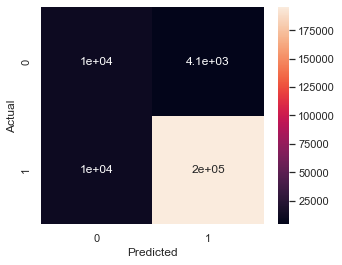

In [45]:
evaluate_results(X_reduced_df, 'dbscan')

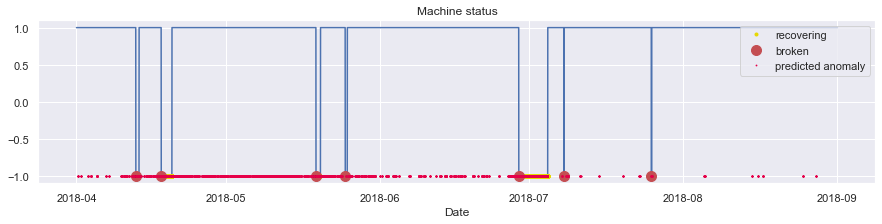

In [46]:
visualize_status(X_reduced_df, 'dbscan')

## <a id='clusters'>Clustering sensors</a>

Clustering sensors based on their scaled values.

In [48]:
df_transposed = df.iloc[:,:-3].T
scaler = StandardScaler()
df_transposed_sc = scaler.fit_transform(df_transposed)


In [49]:
len(df_transposed)

50

In [50]:
def make_metrics_plot(X):
    """
    Visualise clustering metrics to select the optimal k number of clusters
    :X: array
    """
    metrics_col = ['#984447', '#6AA0A0', '#3B402A']
    
    silhouettes = []
    inertia = []
    db = []
    kmin = 2
    kmax = 9
    
    #making a list of scores for each number of clusters
    for k in range(kmin, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(X)
        labels = kmeans.labels_
        silhouettes.append(silhouette_score(X, labels, metric = 'euclidean'))
        inertia.append(kmeans.inertia_)
        db.append(davies_bouldin_score(X, labels))
    
    fig, ax1 = plt.subplots()
    ax1.plot(range(kmin,kmax+1),silhouettes, linestyle='dashed', c=metrics_col[0], label='Silhouette score')
    ax1.set_ylabel('Silhouette score', color=metrics_col[0])
    ax1.set_xlabel('k')
    ax1.tick_params(axis='y', labelcolor=metrics_col[0])
    
    ax2 = ax1.twinx()
    ax2.plot(range(kmin,kmax+1),inertia, c=metrics_col[1], label='Elbow method')
    ax2.set_ylabel('within cluster sum of squares', color=metrics_col[1])
    ax2.tick_params(axis='y', labelcolor=metrics_col[1])
    
    ax3 = ax1.twinx()
    ax3.plot(range(kmin,kmax+1),db, linestyle='dashed', c=metrics_col[2], label='Davies-Bouldin score')
    ax3.spines.right.set_position(("axes", 1.2))
    ax3.set_ylabel('Davies-Bouldin score', color=metrics_col[2])
    ax3.tick_params(axis='y', labelcolor=metrics_col[2])
    
    fig.tight_layout()
    plt.grid(axis='x');

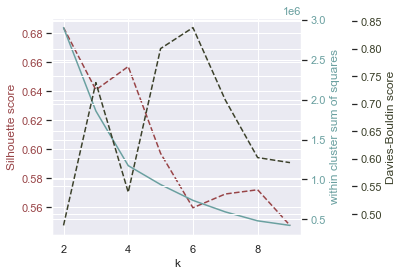

In [52]:
#selecting optimal number of cluster for the kmeans algorithm
make_metrics_plot(df_transposed_sc)

In [53]:
df_transposed.head()

timestamp,2018-04-01 00:00:00,2018-04-01 00:01:00,2018-04-01 00:02:00,2018-04-01 00:03:00,2018-04-01 00:04:00,2018-04-01 00:05:00,2018-04-01 00:06:00,2018-04-01 00:07:00,2018-04-01 00:08:00,2018-04-01 00:09:00,...,2018-08-31 23:50:00,2018-08-31 23:51:00,2018-08-31 23:52:00,2018-08-31 23:53:00,2018-08-31 23:54:00,2018-08-31 23:55:00,2018-08-31 23:56:00,2018-08-31 23:57:00,2018-08-31 23:58:00,2018-08-31 23:59:00
sensor_00,2.465394,2.465394,2.444734,2.460474,2.445718,2.453588,2.455556,2.449653,2.463426,2.445718,...,2.404398,2.402431,2.404398,2.406366,2.396528,2.407350,2.400463,2.396528,2.406366,2.396528
sensor_01,47.092010,47.092010,47.352430,47.092010,47.135410,47.092010,47.048610,47.135410,47.092010,47.178820,...,47.612850,47.699650,47.612850,47.699650,47.612850,47.699650,47.699650,47.699650,47.699650,47.699650
sensor_02,53.211800,53.211800,53.211800,53.168400,53.211800,53.168400,53.168400,53.168400,53.168400,53.168400,...,50.520830,50.520832,50.520832,50.520830,50.564240,50.520830,50.564240,50.520830,50.520832,50.520832
sensor_03,46.310760,46.310760,46.397570,46.397568,46.397568,46.397568,46.397568,46.397568,46.397568,46.397568,...,43.142361,43.142361,43.142361,43.142361,43.142361,43.142361,43.142361,43.142361,43.142361,43.142361
sensor_04,634.375000,634.375000,638.888900,628.125000,636.458300,637.615700,633.333300,630.671300,631.944400,641.782300,...,629.976800,637.963000,637.036987,629.976807,637.962952,634.722229,630.902771,625.925903,635.648100,639.814800


In [54]:
df_transposed_sc_df = pd.DataFrame(df_transposed_sc)

km = KMeans(n_clusters=4, random_state=42)
km = km.fit(df_transposed_sc)

sensor_clusters = km.predict(df_transposed_sc)

In [55]:
df_transposed_sc_df.columns = df_transposed.columns
df_transposed_sc_df.index = df_transposed.index
df_transposed_sc_df.head()

timestamp,2018-04-01 00:00:00,2018-04-01 00:01:00,2018-04-01 00:02:00,2018-04-01 00:03:00,2018-04-01 00:04:00,2018-04-01 00:05:00,2018-04-01 00:06:00,2018-04-01 00:07:00,2018-04-01 00:08:00,2018-04-01 00:09:00,...,2018-08-31 23:50:00,2018-08-31 23:51:00,2018-08-31 23:52:00,2018-08-31 23:53:00,2018-08-31 23:54:00,2018-08-31 23:55:00,2018-08-31 23:56:00,2018-08-31 23:57:00,2018-08-31 23:58:00,2018-08-31 23:59:00
sensor_00,-0.936261,-0.936261,-0.935347,-0.936511,-0.934051,-0.936589,-0.935508,-0.937796,-0.935151,-0.933864,...,-0.954095,-0.955604,-0.957060,-0.957384,-0.956707,-0.951830,-0.956435,-0.955437,-0.955621,-0.955034
sensor_01,-0.785530,-0.785530,-0.785980,-0.788080,-0.785178,-0.786983,-0.787396,-0.788907,-0.786751,-0.785423,...,-0.815166,-0.816555,-0.818397,-0.818518,-0.818413,-0.815071,-0.818609,-0.817896,-0.817632,-0.817595
sensor_02,-0.764860,-0.764860,-0.766491,-0.767871,-0.764935,-0.766618,-0.767070,-0.768806,-0.766546,-0.765548,...,-0.806229,-0.807895,-0.809478,-0.809868,-0.809386,-0.806553,-0.809893,-0.809331,-0.809037,-0.809036
sensor_03,-0.788169,-0.788169,-0.789156,-0.790389,-0.787635,-0.789311,-0.789559,-0.791366,-0.789060,-0.788016,...,-0.828904,-0.830544,-0.832109,-0.832490,-0.832086,-0.828832,-0.832475,-0.831732,-0.831516,-0.831421
sensor_04,1.198077,1.198077,1.181527,1.144270,1.178011,1.192151,1.159894,1.155373,1.158015,1.187693,...,0.974483,0.995386,0.989476,0.966706,0.987176,0.957424,0.955829,0.937609,0.973594,0.978740


In [56]:
df_transposed_sc_df['sensors_k'] = sensor_clusters
df_transposed_sc_df['sensors_k'].value_counts()

0    29
1    14
2     6
3     1
Name: sensors_k, dtype: int64

In [57]:
df_transposed_sc_df[df_transposed_sc_df['sensors_k']==2]

timestamp,2018-04-01 00:00:00,2018-04-01 00:01:00,2018-04-01 00:02:00,2018-04-01 00:03:00,2018-04-01 00:04:00,2018-04-01 00:05:00,2018-04-01 00:06:00,2018-04-01 00:07:00,2018-04-01 00:08:00,2018-04-01 00:09:00,...,2018-08-31 23:51:00,2018-08-31 23:52:00,2018-08-31 23:53:00,2018-08-31 23:54:00,2018-08-31 23:55:00,2018-08-31 23:56:00,2018-08-31 23:57:00,2018-08-31 23:58:00,2018-08-31 23:59:00,sensors_k
sensor_21,2.027701,2.027701,1.984894,1.978248,1.997931,1.979355,1.988197,1.934833,1.988458,1.981885,...,1.781932,1.775288,1.773356,1.772118,1.742091,1.761068,1.746083,1.742392,1.761560,2
sensor_23,2.351750,2.351750,2.325189,2.307029,2.321024,2.321835,2.315602,2.273349,2.323539,2.312736,...,2.443927,2.435151,2.433278,2.429175,2.391002,2.402476,2.397241,2.400324,2.401611,2
sensor_26,1.919856,1.919856,1.883369,1.874706,1.879108,1.892097,1.892701,1.834919,1.892591,1.892929,...,1.493189,1.488723,1.491544,1.477297,1.446197,1.470900,1.467244,1.455132,1.464821,2
sensor_28,1.707482,1.707482,1.646130,1.647730,1.673611,1.660241,1.619861,1.669138,1.690134,1.711101,...,1.479654,1.462229,1.484909,1.468627,1.393689,1.462887,1.464012,1.453163,1.465354,2
sensor_31,1.361680,1.361680,1.457546,1.565180,1.610034,1.516439,1.407270,1.615436,1.444931,1.501863,...,1.770987,1.784850,1.745077,1.809326,1.984880,1.856980,1.844021,1.875753,1.821803,2
sensor_32,1.353672,1.353672,1.367399,1.328042,1.397824,1.438811,1.435112,1.465356,1.289279,1.377654,...,1.789689,1.794393,1.851183,1.801519,1.841799,1.798754,1.851099,1.825988,1.848165,2


In [58]:
df_clusters = df_transposed_sc_df.groupby(['sensors_k']).mean().T
df_clusters['machine_status'] = df['machine_status']
df_clusters.head()

sensors_k,0,1,2,3,machine_status
timestamp,,,,,
2018-04-01 00:00:00,-0.765605,0.734453,1.787023,1.198077,NORMAL
2018-04-01 00:01:00,-0.765605,0.734453,1.787023,1.198077,NORMAL
2018-04-01 00:02:00,-0.767286,0.743230,1.777421,1.181527,NORMAL
2018-04-01 00:03:00,-0.767555,0.743850,1.783489,1.144270,NORMAL
2018-04-01 00:04:00,-0.763806,0.720916,1.813255,1.178011,NORMAL


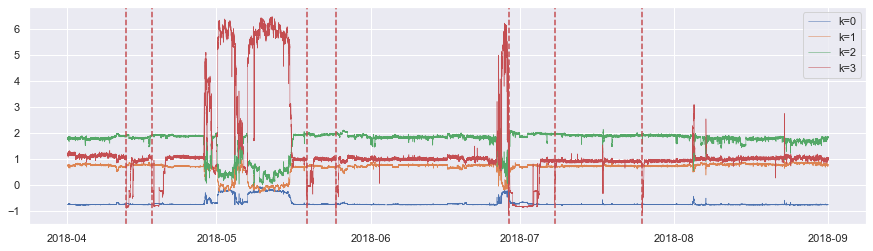

In [59]:
plt.figure(figsize=(15, 4))
plt.plot(df_clusters.iloc[:,0], linewidth=0.5, label="k=0")
plt.plot(df_clusters.iloc[:,1], linewidth=0.5, label="k=1")
plt.plot(df_clusters.iloc[:,2], linewidth=0.5, label="k=2")
plt.plot(df_clusters.iloc[:,3], linewidth=0.5, label="k=3")
[plt.axvline(_x, linestyle='--', color='r') for _x in df[df['machine_status']=='BROKEN'].index.to_list()]
plt.legend(loc="upper right");

In [60]:
df_clusters_X = df_clusters.iloc[:,:-1].to_numpy()

In [61]:
iso_forest = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
print(iso_forest)

y_pred = iso_forest.fit(df_clusters_X).predict(df_clusters_X)
df_clusters['isolation_forest'] = y_pred
print('number of anomalies detected')
print(df_clusters['isolation_forest'].value_counts())

IsolationForest(contamination=0.06574074074074077, n_jobs=-1)
number of anomalies detected
 1    205836
-1     14484
Name: isolation_forest, dtype: int64


              precision    recall  f1-score   support

          -1       0.03      0.03      0.03     14484
           1       0.93      0.93      0.93    205836

    accuracy                           0.87    220320
   macro avg       0.48      0.48      0.48    220320
weighted avg       0.87      0.87      0.87    220320

ROC AUC score:  0.4787467884318679


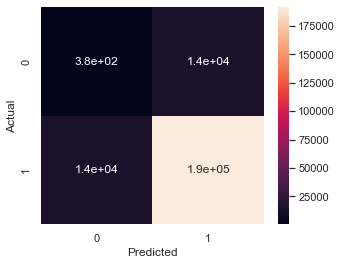

In [62]:
evaluate_results(df_clusters, 'isolation_forest')

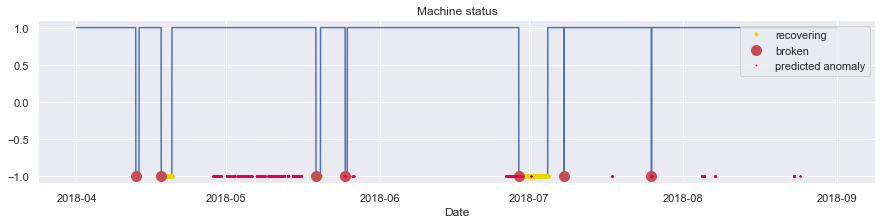

In [63]:
visualize_status(df_clusters, 'isolation_forest')

Perhaps sensors in clusters 2 and 3 affect the anomaly detection as there are vivid outliers in May which were labelled as anomalies.

In [64]:
#first two clusters
df_clusters_X = df_clusters.iloc[:,:2].to_numpy()

In [65]:
iso_forest = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
print(iso_forest)

y_pred = iso_forest.fit(df_clusters_X).predict(df_clusters_X)
df_clusters['isolation_forest'] = y_pred
print('number of anomalies detected')
print(df_clusters['isolation_forest'].value_counts())

IsolationForest(contamination=0.06574074074074077, n_jobs=-1)
number of anomalies detected
 1    205836
-1     14484
Name: isolation_forest, dtype: int64


              precision    recall  f1-score   support

          -1       0.01      0.01      0.01     14484
           1       0.93      0.93      0.93    205836

    accuracy                           0.87    220320
   macro avg       0.47      0.47      0.47    220320
weighted avg       0.87      0.87      0.87    220320

ROC AUC score:  0.4707286451760173


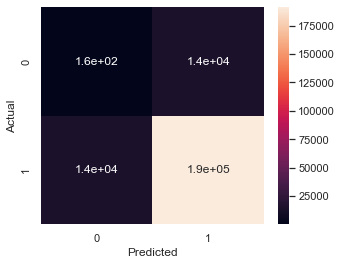

In [66]:
evaluate_results(df_clusters, 'isolation_forest')

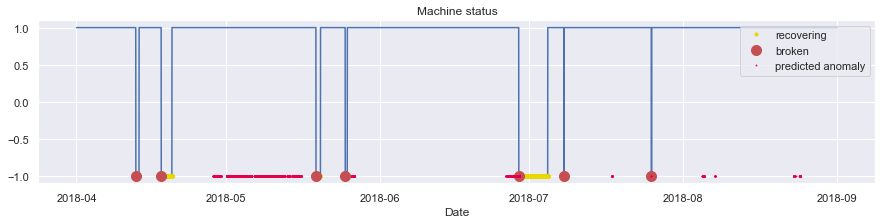

In [67]:
visualize_status(df_clusters, 'isolation_forest')

Switching to applying algorithm only to the first two clusters didn't change the situation much. The difficulty with the problem is that there are no visible anomalous values before machine breaking down, thus algorithm cannot accurately predict the status.

## <a id='conclusion'>Conclusion</a>

We received time series sensor data from the water pump machine. Given data also contained machine status, signaling whether machine was working normally, or there has been a malfunction. The data is for the period of 5 months, from 01-Apr-2018 untill 01-Sep-2018.  
The dataset was preprocessed, empty columns were deleted and empty values were filled with the column mean. The matrix size after preprocessing was 220320x50.  
The following methods were used for the anomaly detection: 

|Method|ROC AUC|TP|FN|FP|TN|
|---|---|---|---|---|---|
|Isolation Forest (raw data)|0.6822|5900|8600|8600|200000|
|Isolation Forest (PCA)|0.7932|8900|5600|5600|200000|
|DBSCAN (raw data)|0.6197|3500|11000|56|210000|
|DBSCAN (PCA)|0.8321|10000|4100|10000|200000|
  
Since the hypothesis was about detecting outliers before machine breaking, amount of False Positives should be above 0. At the same time, we want to keep False Negatives minimal (we want algorithms to identify all outliers that are already labelled as 'Broken' and 'Recovering').

Dimensionality reduction improved ROC AUC for both algorithms, Isolation Forest and DBSCAN. Moreover, it improved ratio of TP to FN (the higher TP and lower FN, the better current anomalies are detected).

Additionally, I've attempted to group sensors with k-means algorithm, resulting in 4 clusters:  

|Method|ROC AUC|TP|FN|FP|TN|
|---|---|---|---|---|---|
|Isolation Forest (all 4 clusters)|0.4787|380|14000|14000|190000|
|Isolation Forest (first 2 clusters)|0.4707|160|14000|14000|190000|

The results from applying Isolation Forest to clustered data showed poor performance. Which suggests that maybe there should be a different approach, perhaps grouping sensors manually.

Some sensors contain outliers that are not reflected in machine working, so it's not clear how the machine obtains the status. 
Also, the imbalance of classes could be the problem.  
As a recommendation it can be suggested to use more data with more cases of machine malfunctioning so that algorithms could detect them more accurately. Getting guidelines regarding machine functioning. Combining unsupervised and supervised algorithms.